##### This notebook is original code by Sam Neubauer, written December 14th, 2020
##### If used, please cite me or my github (S-n00b)

# __Using k-Means Clustering to Determine Ideal Locations to Open an Art Gallery in Research Triangle, North Carolina__
---

---
# __Introduction__
---

#### This project came to life with a real desire to solve a question me and my partner have been trying to answer for a while:

## **Question:**
## **_Where is the best place to open an art gallery in Research Triangle area of North Carolina?_**
### My partner is at a scaling growth stage with her business and wants to open a gallery in the right location of the Research Triangle. This analysis will provide a helpful insight in deciding where to take the next step in her career.

__My partner and I have always known we wanted to move to North Carolina for a number of reasons:__ 
- Our parents both are retired in NC which made it an ideal place to raise kids
- I have a science background and the area has a growing tech sector that would have great job opportunities
- My partner is a successful ceramic artist, and NC is a mecca of sorts for the ceramic community
- The property costs are much more ideal than up north...the list goes on

__Being acquainted with the essential python Data Science & Machine Learning libraries, I thought what not a better way to use my skills than to solve a problem I already had!__

__Below I strive to dig deeper with:__ 
- some Exploratory Data Analysis of the Research Triangle region's art & entertainment venues 
- using the folium package to visualize the distribution of zip codes withing the region
- acquiring popular art and social venue data for each zip code with the Foursquare API
- eventually passing each zip code's common venue types through Scikit Learn's k-Means Clustering   unsupervised Machine Learning algorithm to group the research triangle zip codes into 5 clusters. 

__From there I draw qualitative analysis of the clusters and determine which clusters are the most & least ideal to open an art gallery.__

In [1]:
#import needed libraries
import pandas as pd
import numpy as np

#API libraries
import requests

#visualization libraries
from IPython.display import Image
#
import geocoder
from geopy.geocoders import Nominatim
#
import folium # map rendering library
import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors

#Machine Learning libraries
from sklearn.cluster import KMeans # import k-means from clustering stage

---
---
# __Data__
---

#### CSV file source: https://data.opendatasoft.com/explore/dataset/geonames-postal-code@public-us/download/?format=csv&q=&refine.country_code=US&refine.admin_name1=North+Carolina&timezone=America/New_York&use_labels_for_header=true&csv_separator=%3B

#### The above data source provided a CSV file containing all the zip codes and their respective GPS locations within North Carolina. 

In [2]:
# CSV file source: https://data.opendatasoft.com/explore/dataset/geonames-postal-code@public-us/download/?format=csv&q=&refine.country_code=US&refine.admin_name1=North+Carolina&timezone=America/New_York&use_labels_for_header=true&csv_separator=%3B
df=pd.read_csv('geonames-postal-code.csv', delimiter = ";")
df

,country code,postal code,place name,admin name1,admin code1,admin name2,admin code2,admin name3,admin code3,latitude,longitude,accuracy,coordinates
0,US,27349,Snow Camp,North Carolina,NC,Alamance,1,NaN,NaN,35.9066,-79.4279,4.0,"35.9066,-79.4279"
1,US,28678,Stony Point,North Carolina,NC,Alexander,3,NaN,NaN,35.8661,-81.0641,4.0,"35.8661,-81.0641"
2,US,28675,Sparta,North Carolina,NC,Alleghany,5,NaN,NaN,36.5089,-81.1384,4.0,"36.5089,-81.1384"
3,US,28626,Fleetwood,North Carolina,NC,Ashe,9,NaN,NaN,36.2814,-81.5140,4.0,"36.2814,-81.514"
4,US,28640,Jefferson,North Carolina,NC,Ashe,9,NaN,NaN,36.4090,-81.4396,4.0,"36.409,-81.4396"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076,US,27530,Goldsboro,North Carolina,NC,Wayne,191,NaN,NaN,35.3683,-78.0929,4.0,"35.3683,-78.0929"
1077,US,27863,Pikeville,North Carolina,NC,Wayne,191,NaN,NaN,35.4929,-77.9578,4.0,"35.4929,-77.9578"
1078,US,28578,Seven Springs,North Carolina,NC,Wayne,191,NaN,NaN,35.2105,-77.9146,4.0,"35.2105,-77.9146"
1079,US,28651,Millers Creek,North Carolina,NC,Wilkes,193,NaN,NaN,36.2119,-81.2485,4.0,"36.2119,-81.2485"


In [3]:
df.drop(columns=['country code', 'admin name1','admin code1','admin code2','admin name3','admin code3','accuracy','coordinates'], inplace=True)
df.rename(columns={'postal code':'zip','place name':'place','admin name2':'county','admin code2':'county number'}, inplace=True)
df

,zip,place,county,latitude,longitude
0,27349,Snow Camp,Alamance,35.9066,-79.4279
1,28678,Stony Point,Alexander,35.8661,-81.0641
2,28675,Sparta,Alleghany,36.5089,-81.1384
3,28626,Fleetwood,Ashe,36.2814,-81.5140
4,28640,Jefferson,Ashe,36.4090,-81.4396
...,...,...,...,...,...
1076,27530,Goldsboro,Wayne,35.3683,-78.0929
1077,27863,Pikeville,Wayne,35.4929,-77.9578
1078,28578,Seven Springs,Wayne,35.2105,-77.9146
1079,28651,Millers Creek,Wilkes,36.2119,-81.2485


#### We are only interested in analyzing the zip codes within the counties around the raleigh-durham area, so we will drop all zip code outside of the counties colored green.

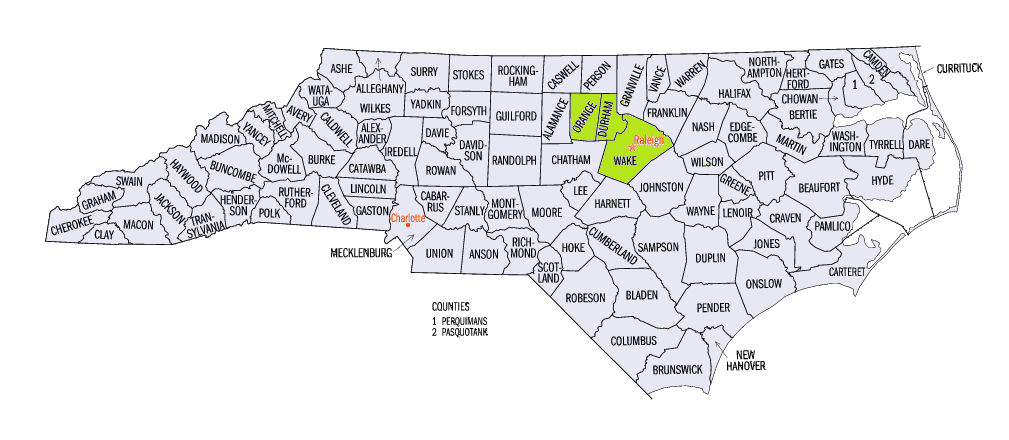

In [4]:
Image(filename='north_carolina_counties_triangle.png') 

#### The 3 core counties of the Research Triangle are Orange, Durham, and Wake.
#### Therefore we will only analyze the zip codes in these counties

In [5]:
df = df[(df.county == 'Orange') | (df.county == 'Durham') | (df.county == 'Wake')]
df.reset_index(drop = True, inplace=True)
df

,zip,place,county,latitude,longitude
0,27704,Durham,Durham,36.0383,-78.8764
1,27710,Durham,Durham,36.0512,-78.8577
2,27711,Durham,Durham,36.0512,-78.8577
3,27529,Garner,Wake,35.6813,-78.5975
4,27615,Raleigh,Wake,35.8887,-78.6393
...,...,...,...,...,...
86,27523,Apex,Wake,35.7225,-78.8408
87,27560,Morrisville,Wake,35.8344,-78.8466
88,27571,Rolesville,Wake,35.9156,-78.4658
89,27602,Raleigh,Wake,35.7587,-78.6711


#### We will use the town of Cary, NC as the center point for our map

In [6]:
address = 'Cary, North Carolina'

geolocator = Nominatim(user_agent="to_explorer")
lat_correction = 0.05
location = geolocator.geocode(address)
latitude = location.latitude + lat_correction
longitude = location.longitude
print('The geograpical coordinate of Cary, North Carolina are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Cary, North Carolina are 35.8382893, -78.7812081.


In [7]:
# create map of North Carolina using latitude and longitude values
map_NC = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for lat, lng, zipc in zip(df['latitude'], df['longitude'], df['zip']):
    label = '{}'.format(zipc)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NC)  
    
map_NC

You will need your own API credentials if you wish to use the Foursquare API. Sign up for the developer free tier account (requires CC) here: 

https://foursquare.com/developers/upgrade

or 

sign up for a sandbox acccount (no CC required, but you will only get 1% of the API calls per day) here:

https://developer.foursquare.com/developer/

In [8]:
CLIENT_ID = 'Enter YOUR CLIENT_ID here' # your Foursquare ID
CLIENT_SECRET = 'Enter YOUR CLIENT_SECRET here' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 1000 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Enter YOUR CLIENT_ID here
CLIENT_SECRET:Enter YOUR CLIENT_SECRET here


In [9]:
df.loc[0, 'zip']

27704

In [10]:
zip_latitude = df.loc[0, 'latitude'] # place latitude value
zip_longitude = df.loc[0, 'longitude'] # place longitude value

zip_code = df.loc[0, 'zip'] # neighborhood name

print('Latitude and longitude values of zip code {} are ({}, {}).'.format(zip_code, 
                                                               zip_latitude, 
                                                               zip_longitude))

Latitude and longitude values of zip code 27704 are (36.0383, -78.8764).


---
### API Section
---

#### Let's query a search for 'Gallery' with a 3 mile radius about the first zip code in the dataframe to make sure the API is firing correctly

In [11]:
LIMIT = 1000 # limit of number of venues returned by Foursquare API
query = 'Gallery'
radius = 4828 # define radius as 3 miles (4.828 km) from zip code center

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    zip_latitude, 
    zip_longitude, 
    query,
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=Enter YOUR CLIENT_ID here&client_secret=Enter YOUR CLIENT_SECRET here&v=20180605&ll=36.0383,-78.8764&query=Gallery&radius=4828&limit=1000'

In [12]:
results = requests.get(url).json()
results

{'meta': {'code': 400,
  'errorType': 'invalid_auth',
  'errorDetail': 'Missing access credentials. See https://developer.foursquare.com/docs/api/configuration/authentication for details.',
  'requestId': '5fd85fdae08ec61add65e49d'},
 'response': {}}

In [13]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
#uncomment to test if API is working correctly (Need API credentials)
# venues = results['response']['groups'][0]['items']
    
# nearby_venues = pd.json_normalize(venues) # flatten JSON

# # filter columns
# filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
# nearby_venues =nearby_venues.loc[:, filtered_columns]

# # filter the category for each row
# nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# # clean columns
# nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

# nearby_venues.head()

In [15]:
# print('{} venues were returned by Foursquare for the {} zip code.'.format(nearby_venues.shape[0],zip_code))

#### Looks good! 
#### Now lets move on to itterating trough all the venue types of interest within the Research Triangle.
-------

## Explore Places in the Research Triangle Area in North Carolina

Instead of returning any venue within a given radius of the zip codes in the Research Triangle area, we will limit our venues types to ones that are more likely to be attended by a patron of an art gallery.

Namely, we will search for the following venue types within a 3 mile radius of each zip code:
   - brewery
   - cocktails
   - distillery
   - gallery
   - museum
   - music venues
   
Patrons of art galleries are often attending social venues & other art venues before/after they go to a gallery.

In [16]:
print('The Foursquare API call limit is: {}'.format(LIMIT))
print('The geographical search radius limit is: {} miles'.format(np.round((radius/1609),1)))

The Foursquare API call limit is: 1000
The geographical search radius limit is: 3.0 miles


#### We will create a function that will easily obtain the information we are interested in via get requests to the Foursquare API. The function will: 
- iterate through all the zip codes in the imported CSV
- pull search results for provided queries
- The API calls will then be transformed into a pandas datarame for easy analysis.

In [17]:
def getNearbyVenues(names, latitudes, longitudes, query, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name,query)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit=1000'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            query,
            radius)
          
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Commented out to preserve API calls when "Run All Cells" executed

In [18]:
# venues = ['brewery', 'cocktails', 'distillery', 'gallery', 'museum', 'music venues']
# df_venues = df_venues[0:0]
# df_venues = pd.DataFrame(columns = ['Zip', 
#                 'Neighborhood Latitude', 
#                 'Neighborhood Longitude', 
#                 'Venue', 
#                 'Venue Latitude', 
#                 'Venue Longitude', 
#                 'Venue Category'])
# for venue in venues:
#     nc_venue = getNearbyVenues(names=df['zip'],
#                                 latitudes=df['latitude'],
#                                 longitudes=df['longitude'],
#                                 query = venue)
#     df_venues = df_venues.append(nc_venue, ignore_index=True)
#     nc_venue.to_csv(path_or_buf='nc_{}_raw.csv'.format(venue))
# df_venues.to_csv(path_or_buf='nc_venues_raw.csv')

In [19]:
# # Validate the shape of the DataFrame from the API calls
# print(df_venues.shape)
# df_venues.tail()

#### Read previously acquired Foursquare API venue data from CSV file

In [20]:
# Comment out if obtaining new API call data
df_venues=pd.read_csv('nc_venues_raw.csv', delimiter = ",")
df_venues.drop(columns=['Unnamed: 0'],inplace=True)
df_venues.reset_index(drop = True, inplace=True)
print('Shape: \t{} \nUnique Venue Types: {} \nUnique Venues: {}'
      .format(df_venues.shape,df_venues['Venue Category'].nunique(),df_venues['Venue'].nunique()))
df_venues.head()

Shape: 	(6045, 7) 
Unique Venue Types: 63 
Unique Venues: 567


,Zip,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,27704,36.0383,-78.8764,Fullsteam Brewery,36.003166,-78.899773,Brewery
1,27704,36.0383,-78.8764,Durham Distillery,36.004452,-78.902913,Brewery
2,27704,36.0383,-78.8764,Durty Bull Brewing Co.,36.001353,-78.898207,Brewery
3,27704,36.0383,-78.8764,Geer Street Garden,36.003601,-78.901057,Gastropub
4,27704,36.0383,-78.8764,Motorco Music Hall,36.003599,-78.900325,Concert Hall


---
---
# __Methodology__
---

### Lets Map The Locations of Existing Art Galleries

In [21]:
df_venue_map = df_venues.drop_duplicates(subset=['Venue'])
vtypes = df_venue_map['Venue Category'].nunique()
print('Shape: \t{} \nUnique Venue Types: {} \nUnique Venues: {}'
      .format(df_venue_map.shape,df_venue_map['Venue Category'].nunique(),df_venue_map['Venue'].nunique()))

Shape: 	(567, 7) 
Unique Venue Types: 63 
Unique Venues: 567


In [22]:
pd.options.mode.chained_assignment = None  # default='warn'

In [23]:
vcode = pd.factorize(list(df_venue_map['Venue Category']))[0]
vcode = list(vcode)
df_venue_map['Venue Code'] = vcode
df_venue_map

,Zip,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Code
0,27704,36.0383,-78.8764,Fullsteam Brewery,36.003166,-78.899773,Brewery,0
1,27704,36.0383,-78.8764,Durham Distillery,36.004452,-78.902913,Brewery,0
2,27704,36.0383,-78.8764,Durty Bull Brewing Co.,36.001353,-78.898207,Brewery,0
3,27704,36.0383,-78.8764,Geer Street Garden,36.003601,-78.901057,Gastropub,1
4,27704,36.0383,-78.8764,Motorco Music Hall,36.003599,-78.900325,Concert Hall,2
...,...,...,...,...,...,...,...,...
5868,27712,36.0918,-78.9299,Choir Ready Room,36.063362,-78.926900,Music Venue,30
5869,27712,36.0918,-78.9299,Barry & Claire Ragin's Home,36.071176,-78.961081,Music Venue,30
5870,27588,35.9731,-78.4508,Hater's Ball,35.941644,-78.475700,Music Venue,30
5871,27607,35.8014,-78.6877,Museum Park Theater,35.809629,-78.703345,Music Venue,30


In [24]:
# create map
map_venue_types = folium.Map(location=[latitude, longitude], zoom_start=10)

#title html
loc = "Research Triangle's Art & Cocktail Venue Locations"
loc2 = "(Color-Coded by Venue Type)"
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)
subtitle_html = '''
             <h2 align="center" style="font-size:14px"><b>{}</b></h2>
             '''.format(loc2)
map_venue_types.get_root().html.add_child(folium.Element(title_html))
map_venue_types.get_root().html.add_child(folium.Element(subtitle_html))

# set color scheme for the clusters
x = np.arange(vtypes)
ys = [i + x + (i*x)**2 for i in range(vtypes)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, vtype, vc in zip(df_venue_map['Venue Latitude'],
                                    df_venue_map['Venue Longitude'],
                                    df_venue_map['Venue'],
                                    df_venue_map['Venue Category'],
                                    df_venue_map['Venue Code']):
    label = folium.Popup('{}  ({})'.format(str(poi),str(vtype)), parse_html=True, max_width=300) 
    #vc = int(vcode[index])
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        popup=label,
        color=rainbow[vc],
        fill=True,
        fill_color=rainbow[vc],
        fill_opacity=0.1).add_to(map_venue_types)
    
map_venue_types.save('venue-type-map.html')       
map_venue_types

#### Look at the top 20 zip codes with the most venues

In [25]:
number_venues = pd.DataFrame(df_venues.groupby('Zip').count())
number_venues = number_venues[['Venue Category']]
number_venues.columns = ['Venue Count']
number_venues.nlargest(10, 'Venue Count')

,Venue Count
Zip,
27608,163
27611,156
27620,156
27621,156
27622,156
27623,156
27624,156
27625,156
27626,156


## Analyze Each Zip Code

In [26]:
# one hot encoding
nc_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nc_onehot['Zip'] = df_venues['Zip'] 

# move neighborhood column to the first column
fixed_columns = [nc_onehot.columns[-1]] + list(nc_onehot.columns[:-1])
nc_onehot = nc_onehot[fixed_columns]

nc_onehot.head()

,Zip,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bar,Beer Garden,Beer Store,...,Southern / Soul Food Restaurant,Speakeasy,Sports Bar,Steakhouse,Tapas Restaurant,Theater,Tiki Bar,Whisky Bar,Wine Bar,Wings Joint
0,27704,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,27704,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,27704,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,27704,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,27704,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [27]:
nc_onehot.shape

(6045, 64)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [28]:
nc_grouped = nc_onehot.groupby('Zip').mean().reset_index()
nc_grouped

,Zip,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bar,Beer Garden,Beer Store,...,Southern / Soul Food Restaurant,Speakeasy,Sports Bar,Steakhouse,Tapas Restaurant,Theater,Tiki Bar,Whisky Bar,Wine Bar,Wings Joint
0,27278,0.000000,0.466667,0.000000,0.0,0.000000,0.066667,0.066667,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,27502,0.000000,0.538462,0.000000,0.0,0.000000,0.000000,0.038462,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,27510,0.065217,0.086957,0.021739,0.0,0.043478,0.000000,0.217391,0.0,0.000000,...,0.0,0.000000,0.021739,0.0,0.021739,0.0,0.0,0.0,0.021739,0.0
3,27511,0.037037,0.148148,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.074074,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,27512,0.000000,0.200000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,27712,0.000000,0.111111,0.111111,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.111111,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
83,27713,0.000000,0.294118,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.058824,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
84,27715,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
85,27717,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


#### Let's confirm the new size

In [29]:
nc_grouped.shape

(87, 64)

#### Let's print the top 5 most common Art & Cocktail venue types for each zipcode


In [30]:
num_top_venues = 5

for hood in nc_grouped['Zip']:
    print("----"+str(hood)+"----")
    temp = nc_grouped[nc_grouped['Zip'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----27278----
            venue  freq
0     Art Gallery  0.47
1  History Museum  0.13
2          Museum  0.07
3             Bar  0.07
4    Cocktail Bar  0.07


----27502----
         venue  freq
0  Art Gallery  0.54
1      Brewery  0.15
2  Music Venue  0.12
3          Pub  0.08
4          Bar  0.04


----27510----
                 venue  freq
0                  Bar  0.22
1              Brewery  0.17
2          Art Gallery  0.09
3  American Restaurant  0.07
4          Music Venue  0.07


----27511----
         venue  freq
0      Brewery  0.22
1          Pub  0.15
2  Art Gallery  0.15
3  Music Venue  0.11
4   Sports Bar  0.07


----27512----
                     venue  freq
0              Music Venue   0.4
1              Art Gallery   0.2
2  New American Restaurant   0.2
3                      Pub   0.2
4                Irish Pub   0.0


----27513----
                 venue  freq
0              Brewery  0.20
1          Art Gallery  0.20
2          Music Venue  0.10
3           Sports Bar

#### Let's put that into a _pandas_ dataframe

First, let's write a function to sort the venues in descending order.

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 Art & Cocktail venues for each neighborhood.

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zip_venues_sorted = pd.DataFrame(columns=columns)
zip_venues_sorted['Zip'] = nc_grouped['Zip']

for ind in np.arange(nc_grouped.shape[0]):
    zip_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nc_grouped.iloc[ind, :], num_top_venues)

print(zip_venues_sorted.shape)
zip_venues_sorted

(87, 11)


,Zip,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,27278,Art Gallery,History Museum,Bar,Museum,Music Venue,Rock Club,Cocktail Bar,BBQ Joint,Beer Garden,Historic Site
1,27502,Art Gallery,Brewery,Music Venue,Pub,Irish Pub,Italian Restaurant,Bar,Dive Bar,Concert Hall,Deli / Bodega
2,27510,Bar,Brewery,Art Gallery,American Restaurant,Music Venue,Museum,Cocktail Bar,Asian Restaurant,Sandwich Place,Distillery
3,27511,Brewery,Art Gallery,Pub,Music Venue,Sports Bar,American Restaurant,Breakfast Spot,Italian Restaurant,Performing Arts Venue,History Museum
4,27512,Music Venue,Pub,Art Gallery,New American Restaurant,Dive Bar,College Basketball Court,Concert Hall,Deli / Bodega,Distillery,Event Space
...,...,...,...,...,...,...,...,...,...,...,...
82,27712,Music Venue,Brewery,Art Gallery,Art Museum,Speakeasy,Wings Joint,Dive Bar,Concert Hall,Deli / Bodega,Distillery
83,27713,Art Gallery,Music Venue,Brewery,Pub,Beer Store,Dive Bar,Concert Hall,Deli / Bodega,Distillery,Event Space
84,27715,Science Museum,Arts & Crafts Store,Brewery,Wings Joint,Event Space,Concert Hall,Deli / Bodega,Distillery,Dive Bar,Gastropub
85,27717,Science Museum,Arts & Crafts Store,Brewery,Wings Joint,Event Space,Concert Hall,Deli / Bodega,Distillery,Dive Bar,Gastropub


## Cluster Zip Codes

#### We will run the _k_-means from the sklearn library to cluster the neighborhood into 6 clusters based on most common venue types. This machine learning algorithm was chosen due to its speed, ease, and the fact that we must use an unsupervised classification method to group the zip codes since there is not an easy and obvious way to characterize the zip codes via explicit (supervised) training methods.

In [33]:
# set number of clusters
kclusters = 6
nc_grouped_clustering = nc_grouped.drop('Zip', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
c_labels = kmeans.labels_
c_labels = c_labels.astype(int)
c_labels

array([0, 0, 1, 1, 5, 1, 1, 1, 1, 1, 5, 5, 0, 4, 5, 0, 4, 4, 5, 2, 4, 0,
       4, 4, 5, 0, 0, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 5, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 4, 1, 1, 1, 1, 1, 3, 3, 3, 5, 5, 3, 3, 1])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [34]:
try:
    # add clustering labels
    zip_venues_sorted.insert(0, 'Cluster Labels', c_labels)

    nc_merged = df

    # merge nc_grouped with nc_data to add latitude/longitude for each neighborhood
    nc_merged = nc_merged.join(zip_venues_sorted.set_index('Zip'), on='zip')
except:
    # drop cluster labels columns incase this cell was already ran
    zip_venues_sorted.drop(columns=['Cluster Labels'],inplace=True)
    # add clustering labels
    zip_venues_sorted.insert(0, 'Cluster Labels', c_labels)

    nc_merged = df

    # merge nc_grouped with nc_data to add latitude/longitude for each neighborhood
    nc_merged = nc_merged.join(zip_venues_sorted.set_index('Zip'), on='zip')
print(nc_merged.shape)
nc_merged.head() # check the last columns!

(91, 16)


,zip,place,county,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,27704,Durham,Durham,36.0383,-78.8764,1.0,Art Gallery,Concert Hall,Brewery,Science Museum,Bar,Music Venue,Gastropub,History Museum,Historic Site,Arts & Crafts Store
1,27710,Durham,Durham,36.0512,-78.8577,3.0,Science Museum,Arts & Crafts Store,Brewery,Wings Joint,Event Space,Concert Hall,Deli / Bodega,Distillery,Dive Bar,Gastropub
2,27711,Durham,Durham,36.0512,-78.8577,3.0,Science Museum,Arts & Crafts Store,Brewery,Wings Joint,Event Space,Concert Hall,Deli / Bodega,Distillery,Dive Bar,Gastropub
3,27529,Garner,Wake,35.6813,-78.5975,5.0,Music Venue,Wings Joint,Sports Bar,Art Gallery,Brewery,Restaurant,American Restaurant,Steakhouse,Speakeasy,General Entertainment
4,27615,Raleigh,Wake,35.8887,-78.6393,4.0,Brewery,Art Gallery,Pizza Place,Pub,American Restaurant,Bar,Sandwich Place,Japanese Restaurant,Beer Store,Speakeasy


---
---
# __Results__
---

Finally, let's visualize the resulting clusters

In [35]:
shape1 = nc_merged.shape[0]
f'{shape1} rows in dataframe'

'91 rows in dataframe'

In [36]:
# Drop rows with no cluster
nc_merged = nc_merged.dropna(subset=['Cluster Labels'],axis=0)
shape2 = nc_merged.shape[0]
shape3 = shape1 - shape2
print('{} zip codes in with clusters in dataframe'.format(shape2))
print('{} zip codes without clusters removed'.format(shape3))

87 zip codes in with clusters in dataframe
4 zip codes without clusters removed


In [37]:
# create CSV file to analyze data
nc_merged.to_csv(path_or_buf='nc_merged.csv')

In [38]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

#title html
loc = "Research Triangle's Zip Codes for Opening an Art Gallery"
loc2 = "(Color-Coded by Venue-based Cluster Type)"
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)
subtitle_html = '''
             <h2 align="center" style="font-size:14px"><b>{}</b></h2>
             '''.format(loc2)
map_clusters.get_root().html.add_child(folium.Element(title_html))
map_clusters.get_root().html.add_child(folium.Element(subtitle_html))

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nc_merged['latitude'], nc_merged['longitude'], nc_merged['zip'], nc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    clust = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[clust],
        fill=True,
        fill_color=rainbow[clust],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters.save('zip-clusters-map.html')       

map_clusters

---
---
# __Discussion__
---

## Examine Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.


## __Cluster 0:__

In [39]:
df_clust0 = nc_merged.loc[nc_merged['Cluster Labels'] == 0, nc_merged.columns[[0,1] + list(range(5, nc_merged.shape[1]))]]
clust0_zips = len(df_clust0.index)
print('{} Zip Codes in Cluster 0:'.format(clust0_zips))
print(list(df_clust0['zip']))

7 Zip Codes in Cluster 0:
[27502, 27539, 27587, 27597, 27278, 27599, 27523]


In [40]:
cnt = ['1st','2nd','3rd','4th','5th']
for count in cnt:
    temp = str(df_clust0[str(count)+' Most Common Venue'].mode())[5:-14]
    print('{} Common: {}'.format(count,temp))

1st Common: Art Gallery
2nd Common: Brewery
3rd Common: Music Venue
4th Common: Pub
5th Common: Irish Pub


### __Cluster 0 Zip Codes:__ 
#### are by far the _**most ideal**_ locations to open an art gallery since galleries are the most common venue found in this cluster. The 4 runner-up venue types condone many social opportunities for the perfect day/night out on the town enjoying music, art, and drinks with friends and/or family.

------------------------------

## __Cluster 1:__

In [41]:
df_clust1 = nc_merged.loc[nc_merged['Cluster Labels'] == 1, nc_merged.columns[[0,1] + list(range(5, nc_merged.shape[1]))]]
clust1_zips = len(df_clust1.index)
print('{} Zip Codes in Cluster 1:'.format(clust1_zips))
print(list(df_clust1['zip']))

53 Zip Codes in Cluster 1:
[27704, 27617, 27636, 27690, 27699, 27619, 27627, 27668, 27705, 27606, 27613, 27650, 27656, 27675, 27697, 27510, 27516, 27517, 27511, 27601, 27621, 27513, 27626, 27603, 27628, 27706, 27514, 27608, 27609, 27625, 27661, 27698, 27605, 27624, 27635, 27676, 27515, 27610, 27612, 27622, 27623, 27640, 27701, 27708, 27607, 27611, 27620, 27634, 27658, 27707, 27722, 27602, 27695]


In [42]:
cnt = ['1st','2nd','3rd','4th','5th']
for count in cnt:
    temp = str(df_clust1[str(count)+' Most Common Venue'].mode())[5:-14]
    print('{} Common: {}'.format(count,temp))

1st Common: Bar
2nd Common: Art Gallery
3rd Common: Music Venue
4th Common: Brewery
5th Common: Cocktail Bar




### __Cluster 1 Zip Codes:__ 
#### are still _**ideal**_ locations to open an art gallery since galleries are the 2nd most common venue found in this cluster. The other top venue types are rich in socializing and live music options. 



------------------------------

## __Cluster 2:__

In [43]:
df_clust2 = nc_merged.loc[nc_merged['Cluster Labels'] == 2, nc_merged.columns[[0,1] + list(range(5, nc_merged.shape[1]))]]
clust2_zips = len(df_clust2.index)
print('{} Zip Code in Cluster 2:'.format(clust2_zips))
print(list(df_clust2['zip']))

1 Zip Code in Cluster 2:
[27562]


In [44]:
cnt = ['1st','2nd','3rd','4th','5th']
for count in cnt:
    temp = str(df_clust2[str(count)+' Most Common Venue'].mode())[5:-14]
    print('{} Common: {}'.format(count,temp))

1st Common: Museum
2nd Common: Wings Joint
3rd Common: Hotel
4th Common: History Museum
5th Common: Historic Site




### __Cluster 2 Zip Codes:__ 
#### is unfortunately the _**least ideal**_ location to open an art gallery since the common venue options lack art, entertainment, and social options. While there is historical destinations, there is not as many cultural opportunities as the other clusters. 



------------------------------------

## __Cluster 3:__

In [45]:
df_clust3 = nc_merged.loc[nc_merged['Cluster Labels'] == 3, nc_merged.columns[[0,1] + list(range(5, nc_merged.shape[1]))]]
clust3_zips = len(df_clust3.index)
print('{} Zip Codes in Cluter 3:'.format(clust3_zips))
print(list(df_clust3['zip']))

6 Zip Codes in Cluter 3:
[27710, 27711, 27709, 27717, 27715, 27702]


In [46]:
cnt = ['1st','2nd','3rd','4th','5th']
for count in cnt:
    temp = str(df_clust3[str(count)+' Most Common Venue'].mode())[5:-14]
    print('{} Common: {}'.format(count,temp))

1st Common: Science Museum
2nd Common: Arts & Crafts Store
3rd Common: Brewery
4th Common: Wings Joint
5th Common: Event Space




### __Cluster 3 Zip Codes:__ 
#### are _**not ideal**_ locations to open an art gallery since there are not entertainment or other cultural common venue options. The event space may hold event that attract customers for an art gallery, but there is less cultural venue density than __Clusters 0, 1, & 4__. 



--------------------------------------------------

## __Cluster 4:__

In [47]:
df_clust4 = nc_merged.loc[nc_merged['Cluster Labels'] == 4, nc_merged.columns[[0,1] + list(range(5, nc_merged.shape[1]))]]
clust4_zips = len(df_clust4.index)
print('{} Zip Codes in Cluter 4:'.format(clust4_zips))
print(list(df_clust4['zip']))

9 Zip Codes in Cluter 4:
[27615, 27526, 27591, 27545, 27614, 27540, 27588, 27703, 27571]


In [48]:
cnt = ['1st','2nd','3rd','4th','5th']
for count in cnt:
    temp = str(df_clust4[str(count)+' Most Common Venue'].mode())[5:-14]
    print('{} Common: {}'.format(count,temp))

1st Common: Brewery
2nd Common: Art Gallery
3rd Common: Wings Joint
4th Common: College Arts Building
1              Wings Joint
5th Common:    Event Space
1    History Museum


### __Cluster 4 Zip Codes:__ 
#### similar to __Cluster 1__, this cluster still highlights _**ideal**_ locations to open an art gallery since galleries are the 2nd most common venue found in this cluster. With eating, drinking, historic locations and a vicinity to college art buildings, these locations may attract a diversity of customer demographics. 
_(Note: 4th/5th Common Venue types had ties in this cluster)_

---

## __Cluster 5:__

In [49]:
df_clust5 = nc_merged.loc[nc_merged['Cluster Labels'] == 5, nc_merged.columns[[0,1] + list(range(5, nc_merged.shape[1]))]]
clust5_zips = len(df_clust5.index)
print('{} Zip Codes in Cluter 5:'.format(clust5_zips))
print(list(df_clust5['zip']))

11 Zip Codes in Cluter 5:
[27529, 27519, 27592, 27616, 27518, 27629, 27604, 27713, 27512, 27712, 27560]


In [50]:
cnt = ['1st','2nd','3rd','4th','5th']
for count in cnt:
    temp = str(df_clust5[str(count)+' Most Common Venue'].mode())[5:-14]
    print('{} Common: {}'.format(count,temp))

1st Common: Music Venue
2nd Common: Brewery
3rd Common: Brewery
4th Common: American Restaurant
5th Common: Speakeasy


### __Cluster 5 Zip Codes:__
#### are _**acceptable**_ locations to open an art gallery. The most common venue type is a music venue which suggests local patrons might appreciate art. However, most of the common venue types include food & drink which doesn't provide much assurance that people going to these venues would frequent an art venue. They are more likely to want to socialize than yearn to experience art.

---
---
# __Conclusion__
---

#### Analyzing the art, music, and social venues of the Research Triangle area has provided a much clearer understanding of the culture and commerce that occurs within the region. We now know that the 6 zip codes within __Cluster 0__ are the _most ideal_ zip codes to open an art gallery, while the zip codes in __Cluster 1__ & __Cluster 4__ are still ideal, providing ample entertainment and socializing opportunities. The 18 zip codes within __Clusters 2, 3, & 5__ are not as ideal candidates to open an art gallery due to having less culturally rich venue opportunities.

#### With this being said, it would be wise to become more familiar with each of these zip codes in person to help get a realistic idea of what each area feels like, and what kind of overhead costs must be endured to open a store-front location.

#### It was very exciting to give insight towards a problem I wanted to solve for my partner's business, and I seriously look forward to making this investigation a reality! Thank you for viewing my project!
